# Final Project

The goal is to pretty much try to create a zero shot model using a SPA-ENG, ENG-FRA datasets from manythings.org. 

The datasets are roughly balanced so for simplicity, downsampling will not be done to even the number of samples. There will be a slight bias coming from the ENG-FRA dataset

## Downloading of data

The data is downloaded from manythings. The data is simply unzipped, and combined for wordpiece modeling.

In [0]:
!wget http://www.manythings.org/anki/spa-eng.zip
!wget http://www.manythings.org/anki/fra-eng.zip

--2019-05-13 00:01:25--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2819791 (2.7M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.69M  9.60MB/s    in 0.3s    

2019-05-13 00:01:26 (9.60 MB/s) - ‘spa-eng.zip’ saved [2819791/2819791]

--2019-05-13 00:01:28--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3423204 (3.3M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   3.26M  12.6MB/s    in 0.3s    


In [0]:
!mkdir fra-eng
!mkdir spa-eng
!mv fra-eng.zip fra-eng
!mv spa-eng.zip spa-eng

In [0]:
!unzip fra-eng/fra-eng.zip -d fra-eng
!unzip spa-eng/spa-eng.zip -d spa-eng

Archive:  fra-eng/fra-eng.zip
  inflating: fra-eng/_about.txt      
  inflating: fra-eng/fra.txt         
Archive:  spa-eng/spa-eng.zip
  inflating: spa-eng/_about.txt      
  inflating: spa-eng/spa.txt         


In [0]:
!ls

fra-eng  sample_data  spa-eng


In [0]:
# Merging the datasets together for wordpiece modeling
!cat fra-eng/fra.txt spa-eng/spa.txt > all.txt

## Modeling

This part will deal with all steps of the model, from creaing the wordpieces to the training of the model.

In [0]:
!pip install sentencepiece # Installing package to deal with converting to wordpiece model

In [0]:
# Installing dev keras 2.2.5 to fix sparse cateogrical accuracy bug
!pip3 install git+https://github.com/keras-team/keras.git -U

  Cloning https://github.com/keras-team/keras.git to /tmp/pip-req-build-5jo2k_ab
  Running command git clone -q https://github.com/keras-team/keras.git /tmp/pip-req-build-5jo2k_ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-chelgl2d/wheels/da/a4/7e/6b7bd9af18cc2e23b8dd5ed6de07a7e13bd80a17214eb88932
Successfully built Keras
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


In [0]:
import sentencepiece as spm

import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Embedding, Dense, Activation, Dropout, RepeatVector, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import shuffle
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
import re

Using TensorFlow backend.


In [0]:
# Set seed for reproducible results
from numpy.random import seed
seed(1)

### Cleaning

#### Wordpiece modeling the corpus

In order to account for unseen words, a subword piece model is used to encode all of the vocabulary in all of the datasets. The model will use all of the words from every sentence in the pairs to build the top pieces to represent the data. 

The following link leads to the tool used to help build the word piece model:  
https://github.com/google/sentencepiece


In [0]:
# Creating a Wordpiece model using all of the data
## Add in the zero shot prefixes
vocab_size= 750
model_prefix = 'model'
train_data_file = 'all.txt'

spm.SentencePieceTrainer.Train(f'--input={train_data_file} --model_prefix={model_prefix} --user_defined_symbols=<2spa>,<2fra>,<2en>,<EOS> --vocab_size={vocab_size} --model_type=bpe')

True

In [0]:
# Loading the piecer
sp = spm.SentencePieceProcessor()
sp.Load("model.model")

True

##### Testing the encoder / decoder

As an additional sanity check, the encoder and decoder is tested here.

In [0]:
sp.EncodeAsPieces("<2en> This is a test")

['▁', '<2en>', '▁This', '▁is', '▁a', '▁t', 'est']

In [0]:
sp.DecodePieces(['▁This', '▁is', '▁a', '▁t', 'est'])

'This is a test'

In [0]:
!head all.txt

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !


In [0]:
sp.EncodeAsPieces("Va !")

['▁V', 'a', '▁!']

In [0]:
sp.DecodePieces(['▁V', 'a', '▁!'])

'Va !'

In [0]:
sp.EncodeAsPieces("sdlfkhsdlkfh")

['▁s', 'd', 'lf', 'k', 'h', 's', 'd', 'l', 'k', 'f', 'h']

In [0]:
sp.EncodeAsPieces("Ça suffit !")

['▁', 'Ç', 'a', '▁su', 'ff', 'it', '▁!']

In [0]:
z = sp.encode_as_ids('<2fra> This is a test <EOS>')
z

[669, 4, 355, 86, 8, 7, 52, 669, 6]

In [0]:
sp.decode_ids(z)

'<2fra> This is a test <EOS>'

#### Preprocessing with the dataset

The data is first loaded and the word pairs are cleanly separated. The target translation tag and end of sentence tags are added to each word. The words are then tokenized using the word piece model and downsampled. The datasets are combined and split into training and testing data sets.

In [0]:
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text and clean up tab delimination into list
        text = file.read().strip().split('\n')
        file.close()
        cleaned_text = [i.split('\t') for i in text]
        return cleaned_text

In [0]:
# Get cleaned corpus
spa_en = read_text("spa-eng/spa.txt")
fra_en = read_text("fra-eng/fra.txt")

In [0]:
# Add in the special characters for translation directions
spa_en = [['<2spa> ' + x[0] + ' <EOS>', '<2en> ' + x[1] + ' <EOS>'] for x in spa_en]
fra_en = [['<2fra> ' + x[0] + ' <EOS>', '<2en> ' + x[1] + ' <EOS>'] for x in fra_en]

In [0]:
spa_en[0]

['<2spa> Go. <EOS>', '<2en> Ve. <EOS>']

[Text(0, 0.5, 'Number of Language Pairs'),
 Text(0.5, 0, 'Language pair'),
 Text(0.5, 1.0, 'Difference between number of language pairs')]

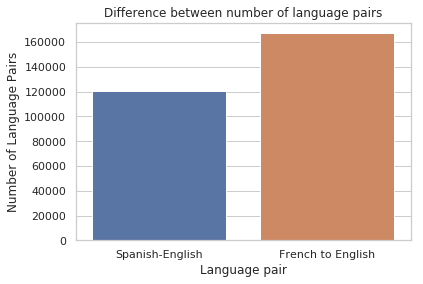

In [0]:
# Look at the number of language pairs
sns.set(style="whitegrid")
g = sns.barplot(['Spanish-English', 'French to English'], [len(spa_en), len(fra_en)])
g.set(xlabel='Language pair', ylabel='Number of Language Pairs', title = "Difference between number of language pairs")

As both datasets are unbalanced, both samples will actually be downsampled down to the target number to balance the datasets and in order to trim down computation time

In [0]:
#Trim down maximum
num_sentences = 30000
shuffle(spa_en)
spa_en = spa_en[:num_sentences]
shuffle(fra_en)
fra_en = fra_en[:num_sentences]

In [0]:
len(spa_en), len(fra_en)

(30000, 30000)

In [0]:
# Tokenize model with wordpiece model version
en_only_spa_wp = [sp.encode_as_ids(i[0]) for i in spa_en]
spa_only_en_wp = [sp.encode_as_ids(i[1]) for i in spa_en]
en_only_fra_wp = [sp.encode_as_ids(i[0]) for i in fra_en]
fra_only_en_wp = [sp.encode_as_ids(i[1]) for i in fra_en]


In [0]:
# Ensure that there are up to 1000 wordmaps from tokenizer
encoder_vocab = set()
for i in spa_only_en_wp:
  for z in i:
    encoder_vocab.add(z)
    
for i in en_only_fra_wp:
  for z in i:
    encoder_vocab.add(z)
    
encoder_vocab_size = len(encoder_vocab) + 1

decoder_vocab = set()
for i in en_only_spa_wp:
  for z in i:
    decoder_vocab.add(z)
    
for i in fra_only_en_wp:
  for z in i:
    decoder_vocab.add(z)
    
decoder_vocab_size = len(decoder_vocab) + 1

In [0]:
print("Encoder vocab size: " + str(encoder_vocab_size))
print("Decoder vocab size: " + str(decoder_vocab_size))

Encoder vocab size: 691
Decoder vocab size: 724


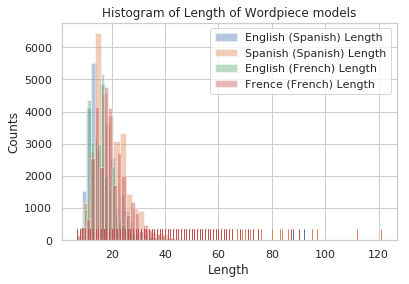

In [0]:
# Check the length of the longest of each dataset
en_only_spa_length = [len(i) for i in en_only_spa_wp]
spa_only_en_length = [len(i) for i in spa_only_en_wp]
en_only_fra_length = [len(i) for i in en_only_fra_wp]
fra_only_en_length = [len(i) for i in fra_only_en_wp]

g = sns.distplot(en_only_spa_length, kde=False, rug=True, label = 'English (Spanish) Length')
g = sns.distplot(spa_only_en_length, kde=False, rug=True, label = 'Spanish (Spanish) Length')
g = sns.distplot(en_only_fra_length, kde=False, rug=True, label = 'English (French) Length')
g = sns.distplot(fra_only_en_length, kde=False, rug=True, label = 'Frence (French) Length')
g.set_title("Histogram of Length of Wordpiece models")
g.set_xlabel("Length")
g.set_ylabel("Counts")
g.legend()
g

In [0]:
max_length = max(max(en_only_spa_length), max(spa_only_en_length), max(en_only_fra_length), max(fra_only_en_length))
max_length

121

Most of the word pieces hover about 15 chunks but the maximum number of chunks is 140 so padding is needed to equalize the length.

In [0]:
# Combine datasets
data = spa_only_en_wp + en_only_fra_wp
targets = en_only_spa_wp + fra_only_en_wp

In [0]:
# Pad length to max len
data = pad_sequences(data,maxlen = max_length, padding='post')
targets = pad_sequences(targets,maxlen = max_length, padding='post')

In [0]:
# Define max length of encoder / decoder, should be the same because of padding
max_encoder_seq_length = max([len(text) for text in data])
max_decoder_seq_length = max([len(text) for text in targets])

In [0]:
max_encoder_seq_length, max_decoder_seq_length

(121, 121)

In [0]:
# Prepare training and test data
train_x, test_x, train_y, test_y = train_test_split(data, targets, test_size=0.2, random_state = 1)
len(train_x), len(test_x), len(train_y), len(test_y)

(48000, 12000, 48000, 12000)

In [0]:
# Inputs (sample_numbers, max sequence length)
train_x.shape, test_x.shape

((48000, 121), (12000, 121))

### Training



In [0]:
batch_size = 128
num_epochs = 10
latent_dim = 512

In [0]:
num_decoder_tokens = decoder_vocab_size
num_encoder_tokens = encoder_vocab_size


In [0]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(Bidirectional(LSTM(units, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True)))
      model.add(LSTM(int(units/2), dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
      model.add(LSTM(int(units/4), dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
      model.add(LSTM(int(units/8), dropout = 0.2, recurrent_dropout = 0.2))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(int(units/8), dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
      model.add(LSTM(int(units/4), dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
      model.add(LSTM(int(units/2), return_sequences=True, dropout = 0.2, recurrent_dropout = 0.2))
      model.add(LSTM(units, return_sequences=True, dropout = 0.2, recurrent_dropout = 0.2))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [0]:
# model compilation
# Endoder/Decoder size defined by vocab size in sentencepiece earlier
# Encoder/Decoder sequence lengths are the same because of padding
model = define_model(vocab_size, vocab_size, max_encoder_seq_length, max_decoder_seq_length, latent_dim)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
adam = optimizers.Adam(lr = 1E-4)
model.compile(loss='sparse_categorical_crossentropy', optimizer= adam, metrics=[metrics.sparse_categorical_accuracy]) # Bug in Keras with reshaping in older version
#model.compile(loss='sparse_categorical_crossentropy', optimizer= adam)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 121, 512)          384000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 121, 1024)         4198400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 121, 256)          1311744   
_________________________________________________________________
lstm_3 (LSTM)                (None, 121, 128)          197120    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 121, 64)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 121, 64)          

In [0]:
# Save checkpoints and tensorboard
filename = 'model5'
callbacks = [ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
            keras.callbacks.TensorBoard(log_dir = 'my_log_dir', histogram_freq = 1, embeddings_freq = 1, embeddings_data = train_y[1:100,])]

#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train model
history = model.fit(train_x, train_y.reshape(train_y.shape[0], train_y.shape[1],1),
                    epochs=num_epochs, batch_size=batch_size, validation_split = 0.2,
                    callbacks=callbacks,
                    validation_data = (test_x, test_y.reshape(test_y.shape[0], test_y.shape[1],1)),
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 859s 18ms/step - loss: 1.3158 - sparse_categorical_accuracy: 0.8511 - val_loss: 0.9034 - val_sparse_categorical_accuracy: 0.8583

Epoch 00001: val_loss improved from inf to 0.90342, saving model to model5
Epoch 2/10
48000/48000 [==============================] - 848s 18ms/step - loss: 0.8983 - sparse_categorical_accuracy: 0.8553 - val_loss: 0.8743 - val_sparse_categorical_accuracy: 0.8528

Epoch 00002: val_loss improved from 0.90342 to 0.87430, saving model to model5
Epoch 3/10
48000/48000 [==============================] - 840s 18ms/step - loss: 0.8712 - sparse_categorical_accuracy: 0.8536 - val_loss: 0.8505 - val_sparse_categorical_accuracy: 0.8577

Epoch 00003: val_loss improved from 0.87430 to 0.85053, saving model to model5
Epoch 4/10
48000/48000 [===

In [0]:
!zip -r tensorboard.zip my_log_dir

updating: my_log_dir/ (stored 0%)
  adding: my_log_dir/keras_embedding.ckpt-5.index (deflated 36%)
  adding: my_log_dir/keras_embedding.ckpt-8.meta (deflated 25%)
  adding: my_log_dir/keras_embedding.ckpt-7.index (deflated 36%)
  adding: my_log_dir/events.out.tfevents.1557710488.03dd2ac60c7f (deflated 80%)
  adding: my_log_dir/keras_embedding.ckpt-6.index (deflated 36%)
  adding: my_log_dir/keras_embedding.ckpt-9.data-00000-of-00001 (deflated 86%)
  adding: my_log_dir/keras_embedding.ckpt-9.index (deflated 37%)
  adding: my_log_dir/keras_embedding.ckpt-7.meta (deflated 25%)
  adding: my_log_dir/keras_embedding.ckpt-5.data-00000-of-00001 (deflated 86%)
  adding: my_log_dir/keras_embedding.ckpt-6.data-00000-of-00001 (deflated 86%)
  adding: my_log_dir/events.out.tfevents.1557709004.03dd2ac60c7f (deflated 25%)
  adding: my_log_dir/keras_embedding.ckpt-8.index (deflated 37%)
  adding: my_log_dir/events.out.tfevents.1557709031.03dd2ac60c7f (deflated 25%)
  adding: my_log_dir/events.out.tfev

In [0]:
# Save model permanently to on prem local(Google Colab)
from google.colab import files
files.download('model5')
files.download('tensorboard.zip')

MessageError: ignored

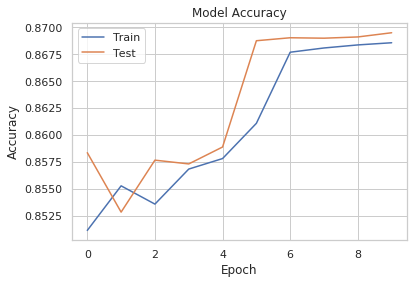

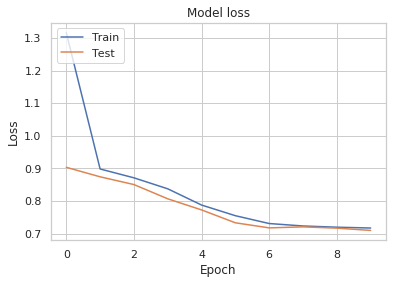

In [0]:
# Plot accuracy & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# Create translate class
class Translate:
  '''
  Translation class
  Input:
  Sentence to translate(string)
  Target Language (French, Spanish, or English)
  Output:
  Translated Sentence
  '''
  def __init__(self, raw_sentence, target_lang):
    self.raw_sentence = raw_sentence
    self.target_lang = target_lang
  
  def encode_sentence(self, sentence):
    '''
    Wordmap the sentence into integers
    '''
    return(sp.encode_as_ids(sentence))
  
  def decode_sentence(self, word_map_vector):
    '''
    Decode the wordmap back into target sentence
    '''
    return(sp.decode_ids(word_map_vector))
  
  def predict_translation(self):
    '''
    Predicts sentence based on target
    '''
    # Append start stop based on target language
    if self.target_lang == 'English':
      input_lang = '<2en> '
    elif self.target_lang == 'French':
      input_lang = '<2fra> '
    elif self.target_lang == 'Spanish':
      input_lang = '<2spa> '
    else:
      return('Error: Please input either English, French or Spanish')
    
    
    # Encode sentence
    sentence = []
    mapped_sentence = self.encode_sentence(input_lang + self.raw_sentence + ' <EOS>')
    sentence.append(mapped_sentence)
    
    # Pad and reshape mapped_sentence
    mapped_sentence = pad_sequences(sentence,maxlen = max_length, padding='post')
    
    # Predict
    prediction = model.predict_classes(mapped_sentence.reshape(mapped_sentence.shape[0], mapped_sentence.shape[1]))
    # Decode from softmax
    prediction = np.trim_zeros(prediction[0], 'b') # Remove the likely padding in the back of the list
    demapped_sentence = self.decode_sentence([int(x) for x in prediction])
    # Return decoded string
    return(demapped_sentence)

##### Testing some translations

These are some sample translations to test the model across directly translated sentence pairs as well as zero shot translations with Spanish to French

In [0]:
# English to French(Explicitly trained)
Translate("I am here.", "French").predict_translation() 


"<2spa> I''t...  "

In [0]:
# Spanish to English(Explicited trained)
Translate("Dónde está el baño", "Spanish").predict_translation()

"<2spa> I''tt to.... "

In [0]:
# Spanish to French(Zero Shot)
Translate("Dónde está el baño", "French").predict_translation() 


"<2spa> I''ttt'.... "

In [0]:
# Testing English to Spanish
Translate("I am here.", "Spanish").predict_translation()

"<2spa> I'' you... "

In [0]:
# English to French(Explicitly trained) with long sentence
Translate("I think bad things are happening but I am not sure what I can do about it. Could you maybe look into it?", "French").predict_translation() 

"<2en>'''''''''''''''''''''''''''''''' "

In [0]:
# Gibberish(multi lang)
Translate("I think el gato est merveilleux", "English").predict_translation() 

"<2spa> I''t.... "

##### BLEU Scores

BLEU scores are evaluated by testing with and against the Google Translate version. There is a pretty higher rate of error due to not super cleaning the output from the prediction such as from the sentence start end tags and the zero padding being decoded.

In [0]:
# BLEU Scores

In [0]:
# ENG to FRENCH(Explicit)
eng_fra_scores = [sentence_bleu(Translate("My name is John.", "French").predict_translation().split(" "), "Mon nom est John.".split(" ")),
                  sentence_bleu(Translate("Where is the bathroom?", "French").predict_translation().split(" "), "Où se trouvent les toilettes?".split(" ")),
                  sentence_bleu(Translate("John, where are you?", "French").predict_translation().split(" "), "John, où es-tu?".split(" "))]
eng_fra_output = [Translate("My name is John.", "French").predict_translation(),
                  Translate("John, where are you?", "French").predict_translation(),
                  Translate("John, where are you?", "French").predict_translation()]

eng_fra_results = pd.DataFrame({'Language': 'ENG-FRA', 
                                'Input_Sentence': ['My name is John.', 'Where is the bathroom', 'John, where are you?'], 
                                'Target_Sentence': ['Mon nom est John.', 'Où se trouvent les toilettes?', 'John, où es-tu?'],
                                'Target_translation': eng_fra_output,
                                'Score': eng_fra_scores})

eng_fra_results

,Language,Input_Sentence,Target_Sentence,Target_translation,Score
0,ENG-FRA,My name is John.,Mon nom est John.,<2spa> I''tt to.....,0
1,ENG-FRA,Where is the bathroom,Où se trouvent les toilettes?,<2en> Je''tt'''....,0
2,ENG-FRA,"John, where are you?","John, où es-tu?",<2en> Je''tt'''....,0


In [0]:
# ENG TO SPANISH(Garbage)
eng_spa_scores = [sentence_bleu(Translate("My name is John.", "Spanish").predict_translation().split(" "), "Mi nombre es John.".split(" ")),
                  sentence_bleu(Translate("Where is the bathroom?", "Spanish").predict_translation().split(" "), "¿Dónde está el baño?".split(" ")),
                  sentence_bleu(Translate("John, where are you?", "Spanish").predict_translation().split(" "), "Juan donde estas".split(" "))]

eng_spa_output = [Translate("My name is John.", "Spanish").predict_translation(),
                  Translate("Where is the bathroom?", "Spanish").predict_translation(),
                  Translate("John, where are you?", "Spanish").predict_translation()]

eng_spa_results = pd.DataFrame({'Language': 'ENG-SPA', 
                                'Input_Sentence': ['My name is John.', 'Where is the bathroom', 'John, where are you?'], 
                                'Target_Sentence': ['Mi nombre es John.', '¿Dónde está el baño?', 'John, où es-tu?'], 
                                'Target_translation': eng_spa_output,
                                'Score': eng_spa_scores})

eng_spa_results

,Language,Input_Sentence,Target_Sentence,Target_translation,Score
0,ENG-SPA,My name is John.,Mi nombre es John.,<2spa> I''tt....,0
1,ENG-SPA,Where is the bathroom,¿Dónde está el baño?,<2spa> I''tt to...,0
2,ENG-SPA,"John, where are you?","John, où es-tu?",<2spa> I''tt to....,0


In [0]:
# SPANISH TO ENG(Explicit)
spa_eng_scores = [sentence_bleu(Translate("Mi nombre es John.", "English").predict_translation().split(" "), "My name is John.".split(" ")),
                  sentence_bleu(Translate("¿Dónde está el baño?", "English").predict_translation().split(" "), "Where is the bathroom?".split(" ")),
                  sentence_bleu(Translate("Juan donde estas", "English").predict_translation().split(" "), "John, where are you?".split(" "))]

spa_eng_output = [Translate("Mi nombre es John.", "English").predict_translation(),
                  Translate("¿Dónde está el baño?", "English").predict_translation(),
                  Translate("Juan donde estas", "English").predict_translation()]

spa_eng_results = pd.DataFrame({'Language': 'SPA-ENG', 
                                'Input_Sentence': ['Mi nombre es John.', '¿Dónde está el baño?', 'Juan donde estas'], 
                                'Target_Sentence': ['My name is John.', 'Where is the bathroom', 'John, where are you?'], 
                                'Target_translation': eng_spa_output,
                                'Score': spa_eng_scores})

spa_eng_results

,Language,Input_Sentence,Target_Sentence,Target_translation,Score
0,SPA-ENG,Mi nombre es John.,My name is John.,<2spa> I''tt....,0
1,SPA-ENG,¿Dónde está el baño?,Where is the bathroom,<2spa> I''tt to...,0
2,SPA-ENG,Juan donde estas,"John, where are you?",<2spa> I''tt to....,0


In [0]:
# SPANISH TO FRENCH(Zero shot)
spa_fra_scores = [sentence_bleu(Translate("Mi nombre es John.", "French").predict_translation().split(" "), "Mon nom est John.".split(" ")),
                  sentence_bleu(Translate("¿Dónde está el baño?", "French").predict_translation().split(" "), "Où se trouvent les toilettes?".split(" ")),
                  sentence_bleu(Translate("Juan donde estas", "French").predict_translation().split(" "), "John, où es-tu?".split(" "))]

spa_fra_output = [Translate("Mi nombre es John.", "French").predict_translation(),
                  Translate("¿Dónde está el baño?", "French").predict_translation(),
                  Translate("Juan donde estas", "French").predict_translation()]

spa_fra_results = pd.DataFrame({'Language': 'SPA-FRA', 
                                'Input_Sentence': ['Mi nombre es John.', '¿Dónde está el baño?', 'Juan donde estas'], 
                                'Target_Sentence': ['Mon nom est John.', 'Où se trouvent les toilettes?', 'John, où es-tu?'], 
                                'Target_translation': spa_fra_output,
                                'Score': spa_fra_scores})

spa_fra_results

,Language,Input_Sentence,Target_Sentence,Target_translation,Score
0,SPA-FRA,Mi nombre es John.,Mon nom est John.,<2spa> I''ttt'....,0
1,SPA-FRA,¿Dónde está el baño?,Où se trouvent les toilettes?,<2en> Je''ttt''....,0
2,SPA-FRA,Juan donde estas,"John, où es-tu?",<2spa> I''tt to....,0


In [0]:
# FRENCH TO ENG(Garbage)
fra_eng_scores = [sentence_bleu(Translate("Mon nom est John.", "French").predict_translation().split("My name is John."), "".split(" ")),
                  sentence_bleu(Translate("Où se trouvent les toilettes?", "French").predict_translation().split("Where is the bathroom?"), "".split(" ")),
                  sentence_bleu(Translate("John, où es-tu?", "French").predict_translation().split(" "), "".split("John, where are you?"))]

fra_eng_output = [Translate("Mon nom est John.", "French").predict_translation(),
                  Translate("Où se trouvent les toilettes?", "French").predict_translation(),
                  Translate("John, où es-tu?", "French").predict_translation()]

fra_eng_results = pd.DataFrame({'Language': 'FRA-ENG', 
                                'Target_Sentence': ['Mon nom est John.', 'Où se trouvent les toilettes?', 'John, où es-tu?'], 
                                'Input_Sentence': ['My name is John.', 'Where is the bathroom', 'John, where are you?'], 
                                'Target_translation': fra_eng_output,
                                'Score': fra_eng_scores})

fra_eng_results

,Language,Target_Sentence,Input_Sentence,Target_translation,Score
0,FRA-ENG,Mon nom est John.,My name is John.,<2spa> I''ttt'....,0
1,FRA-ENG,Où se trouvent les toilettes?,Where is the bathroom,<2en> Je'''''''''....,0
2,FRA-ENG,"John, où es-tu?","John, where are you?",<2en> Je''tt'''....,0


In [0]:
# FRENCH TO SPANISH(Garbage)
fra_spa_scores = [sentence_bleu(Translate("Mon nom est John.", "Spanish").predict_translation().split(" "), "Mi nombre es John.".split(" ")),
                  sentence_bleu(Translate("Où se trouvent les toilettes?", "Spanish").predict_translation().split(" "), "¿Dónde está el baño?".split(" ")),
                  sentence_bleu(Translate("John, où es-tu?", "Spanish").predict_translation().split(" "), "Juan donde estas".split(" "))]

fra_spa_output = [Translate("Mon nom est John.", "Spanish").predict_translation(),
                  Translate("Où se trouvent les toilettes?", "Spanish").predict_translation(),
                  Translate("John, où es-tu?", "Spanish").predict_translation()]

fra_spa_results = pd.DataFrame({'Language': 'FRA-SPA', 
                                'Input_Sentence': ['Mon nom est John.', 'Où se trouvent les toilettes?', 'John, où es-tu?'], 
                                'Target_Sentence': ['Mi nombre es John.', '¿Dónde está el baño?', 'Juan donde estas'], 
                                'Target_translation': fra_spa_output,
                                'Score': fra_spa_scores})

fra_spa_results

,Language,Input_Sentence,Target_Sentence,Target_translation,Score
0,FRA-SPA,Mon nom est John.,Mi nombre es John.,<2spa> I''tt to...,0
1,FRA-SPA,Où se trouvent les toilettes?,¿Dónde está el baño?,<2en> Je''ttt''....,0
2,FRA-SPA,"John, où es-tu?",Juan donde estas,<2spa> I''tt to....,0


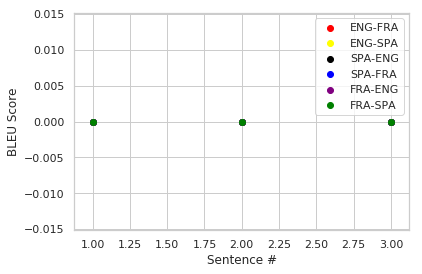

In [0]:
# Plot results
plt.scatter([1,2,3], eng_fra_results['Score'], color = "red", label = 'ENG-FRA', linestyle = '-', marker = 'o')
plt.scatter([1,2,3], eng_spa_results['Score'], color = "yellow", label = 'ENG-SPA', linestyle = '-', marker = 'o')
plt.scatter([1,2,3], spa_eng_results['Score'], color = "black", label = 'SPA-ENG', linestyle = '-', marker = 'o')
plt.scatter([1,2,3], spa_fra_results['Score'], color = "blue", label = 'SPA-FRA', linestyle = '-', marker = 'o')
plt.scatter([1,2,3], fra_eng_results['Score'], color = "purple", label = 'FRA-ENG', linestyle = '-', marker = 'o')
plt.scatter([1,2,3], fra_spa_results['Score'], color = "green",label = 'FRA-SPA', linestyle = '-', marker = 'o')
plt.ylabel('BLEU Score')
plt.xlabel('Sentence #')
plt.legend()
plt.show()
